In [1]:
import json
import random
import tqdm
from tqdm import tqdm

import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append("..")

from scripts.utils import *

## 1. Load data

In [3]:
d = load_data("../data/citation_generation/test_dataset.jsonl")
dataset = pd.DataFrame.from_dict(d).T
display(dataset.head())
print(f"Total number of rows: {len(dataset)}")

100it [00:00, 11737.90it/s]


,citation_sentence,manuscript_id,cited_id,cited_text,manuscript_result_text
0,"In addition, we here report comparable changes...",8281087,15228934,ietary incorporation of plant sterols and stan...,The systematic search retrieved 1084 potentia...
1,"In addition, we here report comparable changes...",8281087,20547173,Elevated plasma total cholesterol (TC) 5 and L...,The systematic search retrieved 1084 potentia...
2,"In addition, we here report comparable changes...",8281087,15671550,"Phytosterols (PS), comprising both plant stero...",The systematic search retrieved 1084 potentia...
3,Such a discrepancy may likely be due to dose-o...,8281923,6704669,"3,4-Methylenedioxymethamphetamine (MDMA; ""ecst...",Two earlier studies have reported that male 5...
4,"Similar to earlier observations (42) , the inf...",11155963,4009171,Plasmodium falciparum is metabolically highly ...,"Cell membrane scrambling, a hallmark of erypt..."


Total number of rows: 100


In [4]:
i = 0
citation_sentence = dataset.loc[i, "citation_sentence"]
cited_text = dataset.loc[i, "cited_text"]
manuscript_result_text = dataset.loc[i, "manuscript_result_text"]

print(citation_sentence)

In addition, we here report comparable changes in serum cholesterol and lipoprotein concentrations as found in previously published meta-analyses [1] [2] [3] , implying that the included studies in this meta-analyses are representative of all available studies in the literature that have been performed with plant sterols and plant stanols.


## 2. Tokenize texts into sentences

In [5]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters


# tokenizer should not split at abbrieviations
punkt_params = PunktParameters()
punkt_params.abbrev_types = set(["i.e", "e.g", "etc", "al", "fig", "figs", 
                                 "ref", "refs", "p", "c", "s"]) 

# initialise sentence tokenizer
tokenizer = PunktSentenceTokenizer(punkt_params)

In [6]:
# tokenize manuscript_result_text, cited_text into sentences
query_sentences = tokenizer.tokenize(manuscript_result_text)
cited_sentences = tokenizer.tokenize(cited_text)

for j in range(10): print(query_sentences[j])
print()
for j in range(10): print(cited_sentences[j])

 The systematic search retrieved 1084 potentially relevant papers, and after two selection rounds, 41 RCTs were included in the meta-analysis.
A flowchart of the study selection process is presented in Fig. 1 .
Of the 41 included studies (Online Supplemental Material Tables 1 and 2 ), 23 were conducted as a parallel study [15-17, 19, 21-26, 28-31, 34, 38-45] and 18 studies had a crossover design [13, 14, 18, 20, [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [56] [57] [58] [59]  The weighted effects of plant sterol or plant stanol consumption on plasma fat-soluble vitamin and carotenoid concentrations are presented in Table 1 .
Non-standardized and TC-standardized hydrocarbon carotenoid concentrations, i.e., lycopene, α-carotene and β-carotene, were significantly (P < 0.0001) lowered after consumption of plant sterol-or plant stanol-enriched foods.
β-Carotene For parallel studies, the weighted average baseline concentrations were calculated based on the baseline concentrations in th

## 3. Compute sentence embeddings

In [7]:
# import sent2vec

# model = sent2vec.Sent2vecModel()
# model.load_model('model.bin') 
# emb = model.embed_sentence("once upon a time .") 
# embs = model.embed_sentences(["first sentence .", "another sentence"])

- I've been unable to download any of the .bin files from https://github.com/epfml/sent2vec

In [8]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("stsb-distilbert-base")

In [9]:
# compute sentence embeddings
query_embeddings = model.encode(query_sentences)
cited_embeddings = model.encode(cited_sentences)

## 4. Compute sentence similarity scores

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(query_embeddings, cited_embeddings)
print(similarity.shape)

(23, 152)


In [11]:
k = 5
indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]
indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
topk_similarity = similarity.flatten()[indices]

topk_sentence_pairs = []
for i in range(k): 
    ind = indices[i]
    a = ind // similarity.shape[1]
    b = ind % similarity.shape[1]
    topk_sentence_pairs.append([(a,b), topk_similarity[i], 
                                    query_sentences[a], 
                                    cited_sentences[b]])

for s in topk_sentence_pairs:
    print(s[1:])
    print()

[0.7383168, 'Non-standardized and TC-standardized hydrocarbon carotenoid concentrations, i.e., lycopene, α-carotene and β-carotene, were significantly (P < 0.0001) lowered after consumption of plant sterol-or plant stanol-enriched foods.', "In conclusion, plant sterol/stanol containing products significantly reduced LDL concentrations but the reduction was related to individuals' baseline LDL levels, food carrier, frequency and time of intake."]

[0.7263868, 'HDL-C concentrations did not change after plant sterol or plant stanol consumption (0.2 %), while TAG concentrations were significantly (P < 0.0001) decreased by 0.06 mmol/L (−4.6 %) ( Table 1) .', 'For instance, plant sterols/stanols consumed 2Á3 times/day reduced LDL cholesterol levels by 0.34 mmol/L (95% CI: (0.38, (0.18) while plant sterols/stanols consumed once per day in the morning did not result in a significant reduction in LDL levels.']

[0.67912066, 'Non-standardized and TC-standardized hydrocarbon carotenoid concentrat

In [12]:
topk_cited_sentences = " ".join([p[-1] for p in topk_sentence_pairs])
print(topk_cited_sentences)
print()
print(citation_sentence)

In conclusion, plant sterol/stanol containing products significantly reduced LDL concentrations but the reduction was related to individuals' baseline LDL levels, food carrier, frequency and time of intake. For instance, plant sterols/stanols consumed 2Á3 times/day reduced LDL cholesterol levels by 0.34 mmol/L (95% CI: (0.38, (0.18) while plant sterols/stanols consumed once per day in the morning did not result in a significant reduction in LDL levels. Plat et al. (31) showed that 2.5 g of plant stanols in margarines and shortenings consumed for four weeks once per day at lunch or divided over three meals, lowered LDL cholesterol levels to a similar extent, about 10%. The present meta-analysis has confirmed that baseline LDL cholesterol levels affect magnitude of reduction in LDL after plant sterol/stanol consumption which could explain the wide variation in responsiveness seen in previous studies. Another (5) looked at the efficacy and safety of plant sterols/stanols as cholesterol lo

In [13]:
for i in range(1,5):
    print(rouge_n(citation_sentence, topk_cited_sentences, n=i))

0.9354838709677419
0.8321678321678322
0.5942622950819673
0.43853820598006643


In [14]:
def get_topk_citation_sentences(manuscript_result_text, cited_text, k=5):
    # TODO: reject sentences with scores < some threshold
    
    # tokenize into sentences
    query_sentences = tokenizer.tokenize(manuscript_result_text)
    cited_sentences = tokenizer.tokenize(cited_text)

    # compute embeddings and cosine similarity matrix
    query_embeddings = model.encode(query_sentences)
    cited_embeddings = model.encode(cited_sentences)
    similarity = cosine_similarity(query_embeddings, cited_embeddings)
    
    # get indices of highest similarity scores 
    indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]
    
    # get indices in decreasing order wrt scores
    indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])

    # return 
    topk_cited_sentences = []
    for ind in indices: 
        b = ind % similarity.shape[1]
        topk_cited_sentences.append(cited_sentences[b])

    return topk_cited_sentences

## 5. Extractively summarize the entire dataset

In [15]:
all_topk_cited_sentences = dataset[["manuscript_result_text", "cited_text"]].apply(
    lambda row: get_topk_citation_sentences(*row), axis=1
)
print(all_topk_cited_sentences[0])

["In conclusion, plant sterol/stanol containing products significantly reduced LDL concentrations but the reduction was related to individuals' baseline LDL levels, food carrier, frequency and time of intake.", 'For instance, plant sterols/stanols consumed 2Á3 times/day reduced LDL cholesterol levels by 0.34 mmol/L (95% CI: (0.38, (0.18) while plant sterols/stanols consumed once per day in the morning did not result in a significant reduction in LDL levels.', 'Plat et al. (31) showed that 2.5 g of plant stanols in margarines and shortenings consumed for four weeks once per day at lunch or divided over three meals, lowered LDL cholesterol levels to a similar extent, about 10%.', 'The present meta-analysis has confirmed that baseline LDL cholesterol levels affect magnitude of reduction in LDL after plant sterol/stanol consumption which could explain the wide variation in responsiveness seen in previous studies.', 'Another (5) looked at the efficacy and safety of plant sterols/stanols as 

In [16]:
dataset["topk_cited_sentences"] = all_topk_cited_sentences
display(dataset.head())

,citation_sentence,manuscript_id,cited_id,cited_text,manuscript_result_text,topk_cited_sentences
0,"In addition, we here report comparable changes...",8281087,15228934,ietary incorporation of plant sterols and stan...,The systematic search retrieved 1084 potentia...,"[In conclusion, plant sterol/stanol containing..."
1,"In addition, we here report comparable changes...",8281087,20547173,Elevated plasma total cholesterol (TC) 5 and L...,The systematic search retrieved 1084 potentia...,[stanols) had no noticeable impact on the LDL-...
2,"In addition, we here report comparable changes...",8281087,15671550,"Phytosterols (PS), comprising both plant stero...",The systematic search retrieved 1084 potentia...,"[Irrespective of the type of PS used, liquid f..."
3,Such a discrepancy may likely be due to dose-o...,8281923,6704669,"3,4-Methylenedioxymethamphetamine (MDMA; ""ecst...",Two earlier studies have reported that male 5...,[This suggests that 5-HT 2C R stimulation can ...
4,"Similar to earlier observations (42) , the inf...",11155963,4009171,Plasmodium falciparum is metabolically highly ...,"Cell membrane scrambling, a hallmark of erypt...","[Taken together, lack of ClC-2 did not prevent..."


In [17]:
rouge_unigrams = []
rouge_bigrams = []
for _, row in dataset.iterrows():
    rouge_unigrams.append(rouge_n(row.citation_sentence, " ".join(row.topk_cited_sentences), n=1))
    rouge_bigrams.append(rouge_n(row.citation_sentence, " ".join(row.topk_cited_sentences), n=2))

In [18]:
dataset["rouge_1"] = rouge_unigrams
dataset["rouge_2"] = rouge_bigrams
display(dataset.head())

,citation_sentence,manuscript_id,cited_id,cited_text,manuscript_result_text,topk_cited_sentences,rouge_1,rouge_2
0,"In addition, we here report comparable changes...",8281087,15228934,ietary incorporation of plant sterols and stan...,The systematic search retrieved 1084 potentia...,"[In conclusion, plant sterol/stanol containing...",0.935484,0.832168
1,"In addition, we here report comparable changes...",8281087,20547173,Elevated plasma total cholesterol (TC) 5 and L...,The systematic search retrieved 1084 potentia...,[stanols) had no noticeable impact on the LDL-...,0.903226,0.769231
2,"In addition, we here report comparable changes...",8281087,15671550,"Phytosterols (PS), comprising both plant stero...",The systematic search retrieved 1084 potentia...,"[Irrespective of the type of PS used, liquid f...",0.903226,0.769231
3,Such a discrepancy may likely be due to dose-o...,8281923,6704669,"3,4-Methylenedioxymethamphetamine (MDMA; ""ecst...",Two earlier studies have reported that male 5...,[This suggests that 5-HT 2C R stimulation can ...,0.975000,0.616352
4,"Similar to earlier observations (42) , the inf...",11155963,4009171,Plasmodium falciparum is metabolically highly ...,"Cell membrane scrambling, a hallmark of erypt...","[Taken together, lack of ClC-2 did not prevent...",0.937500,0.838095


array([[<AxesSubplot:title={'center':'rouge_1'}>,
        <AxesSubplot:title={'center':'rouge_2'}>]], dtype=object)

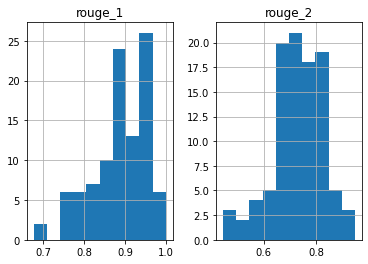

In [22]:
dataset.hist()

In [19]:
import torch
from transformers import pipeline

device = check_gpu()

There is 1 GPU(s) available.
Device name: GeForce RTX 2070


In [20]:
# load pipeline with BART model,  trained on the CNN/Daily Mail News Dataset
summarizer = pipeline("summarization")